# Clustering

**Importation**


**This assignment aims to apply clustering techniques to an unlabeled sound dataset, analyze the necessity of dimensionality reduction, and compare different clustering methods. Students will experiment with feature visualization, clustering performance metrics, and interpretability.**


In [30]:

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


**Setup visualization style**

In [31]:

# Setup visualization style
sns.set(style="whitegrid")

# Load audio data

In [32]:



unlabelled_data_path = "/kaggle/input/sound-data/unlabelled_sounds"
features = []

# Extract Mel spectrogram features
for f in tqdm(os.listdir(unlabelled_data_path)):
    if f.endswith(".wav"):
        file_path = os.path.join(unlabelled_data_path, f)
        y, sr = librosa.load(file_path, sr=None)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
        log_mel = librosa.power_to_db(mel)
        # Combine mean and std of Mel bands
        features.append(np.concatenate([log_mel.mean(axis=1), log_mel.std(axis=1)]))
        
features_array = np.array(features)


100%|██████████| 3000/3000 [00:18<00:00, 165.45it/s]


# Visualizing raw features

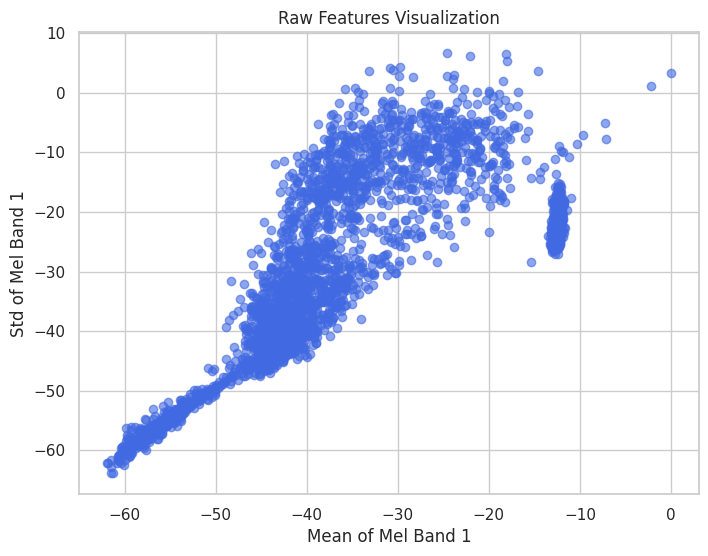

In [33]:

plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.6, c='royalblue')
plt.xlabel("Mean of Mel Band 1")
plt.ylabel("Std of Mel Band 1")
plt.title("Raw Features Visualization")
plt.grid(True)
plt.show()


# Pair plots

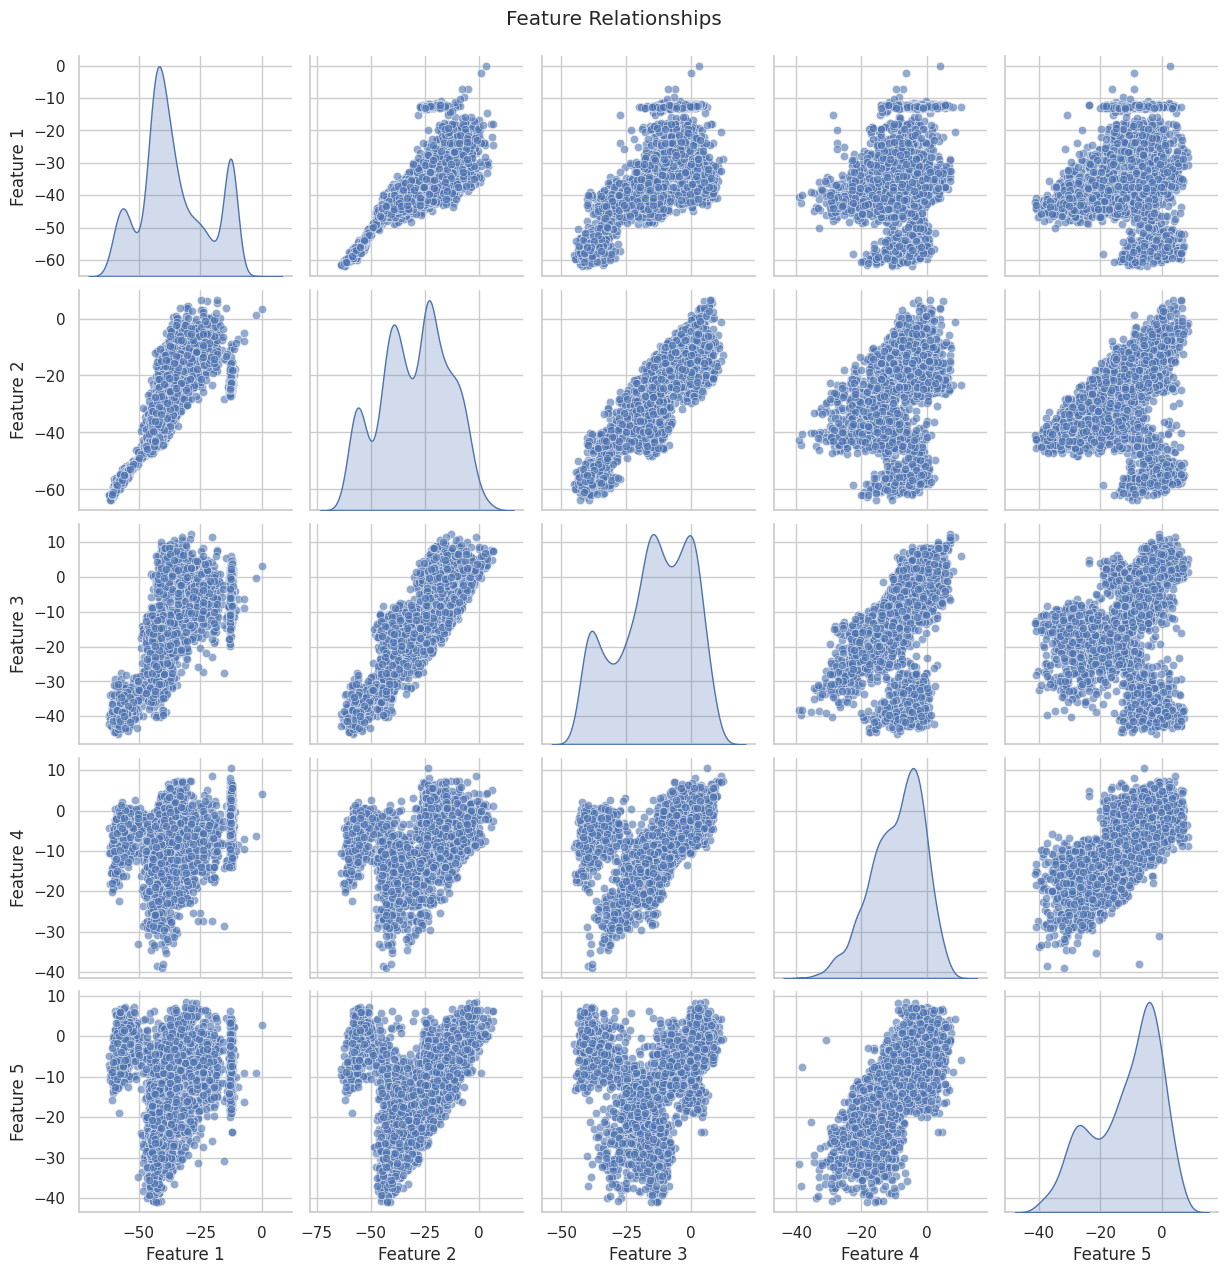

In [34]:

# Pair plot for first 5 features
df = pd.DataFrame(features_array[:, :5], columns=[f'Feature {i+1}' for i in range(5)])
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle("Feature Relationships", y=1.02)
plt.show()



# Comment

**Why is dimensionality reduction important?**

Based on the visualisations, the raw feature plot shows data points compacted together without clear separation - this is exactly why dimensionality reduction is essential:
1. To remove redundancy in the data, thus reducing unnecessary noise. Dimensionality reduction enhances feature correlation.
2. To  enhance data visualisation, enabling human pattern recognition.
3. To increase clustering algorithm performance since they struggle with irrelevant features and scale differences in the dataset.
   

# Standardization and Dimensionality Reduction

In [35]:
# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Dimensionality reduction
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_scaled)



# Compare PCA vs t-SNE

**3d Visualisations**

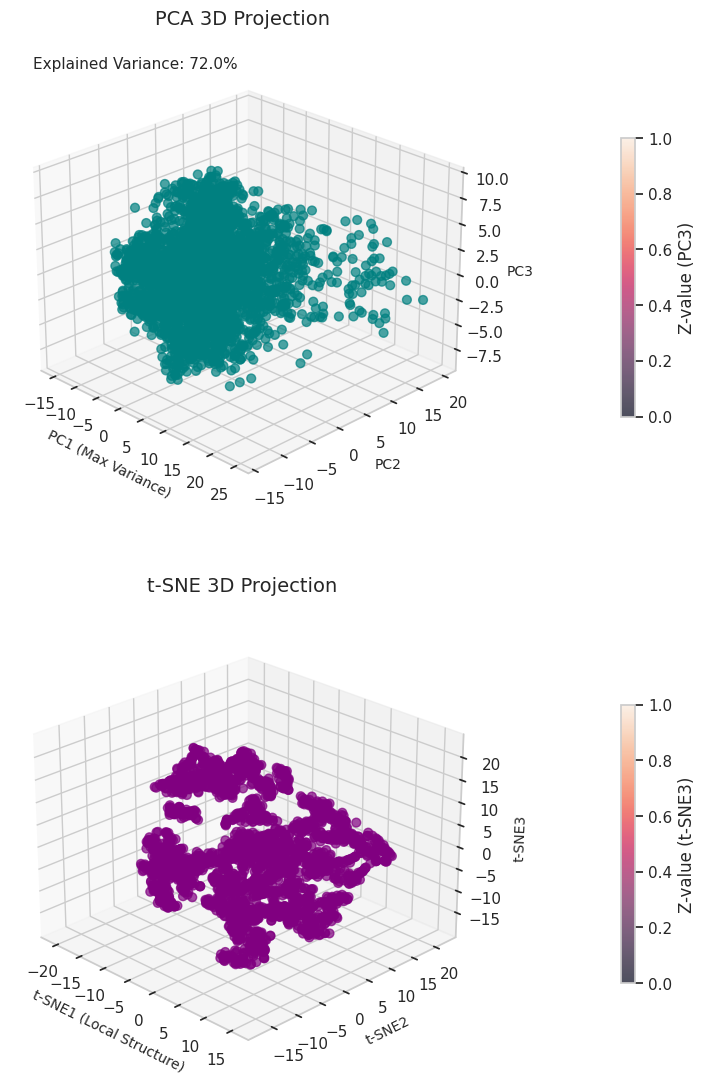

In [46]:
# Compare PCA vs t-SNE (3D Visualization)
fig = plt.figure(figsize=(16, 12))

# PCA - Top plot
ax1 = fig.add_subplot(211, projection='3d')
sc1 = ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], 
                 alpha=0.7, c='teal', s=40, depthshade=True)
ax1.set_title("PCA 3D Projection", fontsize=14, pad=15)
ax1.set_xlabel("PC1 (Max Variance)", fontsize=10)
ax1.set_ylabel("PC2", fontsize=10)
ax1.set_zlabel("PC3", fontsize=10)
ax1.view_init(elev=25, azim=-45)  # Optimal viewing angle
ax1.dist = 10  # Adjust viewing distance

# Add explained variance information
var_ratio = pca.explained_variance_ratio_
ax1.text2D(0.05, 0.95, f"Explained Variance: {sum(var_ratio)*100:.1f}%", 
          transform=ax1.transAxes, fontsize=11,
          bbox=dict(facecolor='white', alpha=0.8))

# t-SNE - Bottom plot
ax2 = fig.add_subplot(212, projection='3d')
sc2 = ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], 
                 alpha=0.7, c='purple', s=40, depthshade=True)
ax2.set_title("t-SNE 3D Projection", fontsize=14, pad=15)
ax2.set_xlabel("t-SNE1 (Local Structure)", fontsize=10)
ax2.set_ylabel("t-SNE2", fontsize=10)
ax2.set_zlabel("t-SNE3", fontsize=10)
ax2.view_init(elev=25, azim=-45)  # Consistent viewing angle
ax2.dist = 10  # Consistent viewing distance

# Add colorbars for depth perception
fig.colorbar(sc1, ax=ax1, label='Z-value (PC3)', shrink=0.6, pad=0.1)
fig.colorbar(sc2, ax=ax2, label='Z-value (t-SNE3)', shrink=0.6, pad=0.1)

plt.tight_layout(pad=4.0)
plt.show()

# Comparative Dimensionality Reduction Scatter Plot

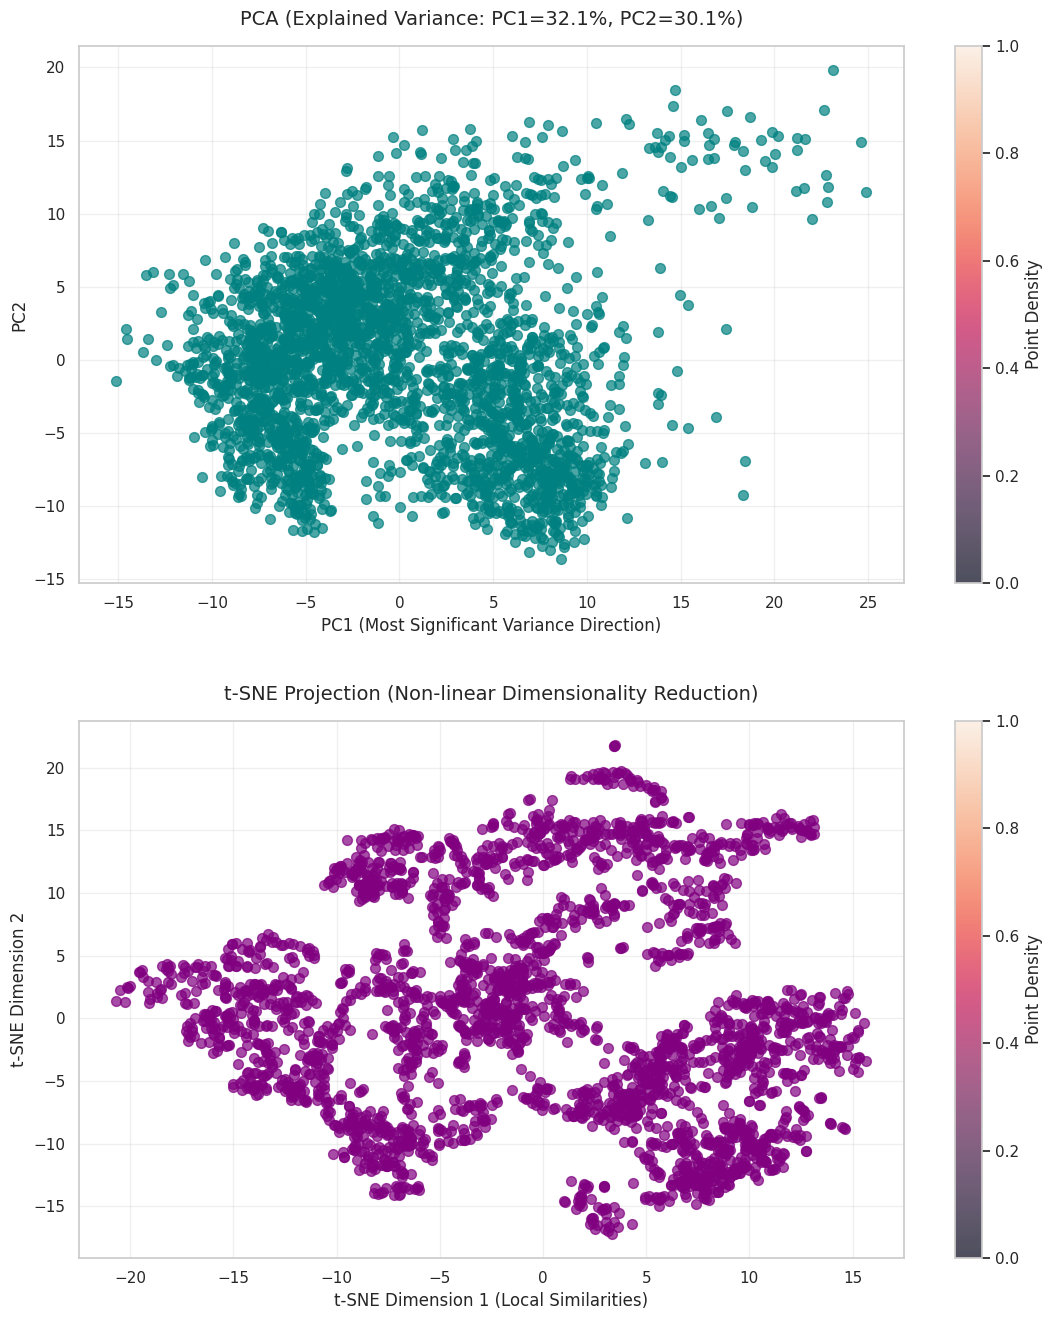

In [45]:
# Compare PCA vs t-SNE (vertical arrangement)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

# PCA - Top plot
sc1 = ax1.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.7, c='teal', s=50)
ax1.set_title("PCA Projection (First Two Principal Components)", fontsize=14, pad=15)
ax1.set_xlabel("PC1 (Most Significant Variance Direction)", fontsize=12)
ax1.set_ylabel("PC2", fontsize=12)
ax1.grid(True, alpha=0.3)

# Add explained variance ratio to title
var_ratio = pca.explained_variance_ratio_
ax1.set_title(f"PCA (Explained Variance: PC1={var_ratio[0]*100:.1f}%, PC2={var_ratio[1]*100:.1f}%)", 
             fontsize=14, pad=15)

# t-SNE - Bottom plot
sc2 = ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], alpha=0.7, c='purple', s=50)
ax2.set_title("t-SNE Projection (Non-linear Dimensionality Reduction)", fontsize=14, pad=15)
ax2.set_xlabel("t-SNE Dimension 1 (Local Similarities)", fontsize=12)
ax2.set_ylabel("t-SNE Dimension 2", fontsize=12)
ax2.grid(True, alpha=0.3)

# Add colorbars for density visualization
plt.colorbar(sc1, ax=ax1, label='Point Density')
plt.colorbar(sc2, ax=ax2, label='Point Density')

plt.tight_layout(pad=3.0)
plt.show()

# Comment

**Which method (PCA or t-SNE) provides better separability of clusters and why?**

Based on the visualisations, it is clear that t-SNE has provided better separability compared to PCA. This is mainly because of the following reasons:

1. t-SNE can reveal non-linear relationships in high-dimensional data. Since audio data often has complex curved boundaries between clusters, the linear technique used by PCA cannot capture such complexity.


2. t-SNE also pulls similar points together, thus creating a distinct differentiation between clusters. As illustrated in the visualisations, the PCA suffers from the crowding problem where points get compressed at the centre; hence, the t-SNE  with its Student t-distribution in low dimensions, prevents this.
   

In [37]:
# Determine optimal clusters for KMeans
inertias = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)



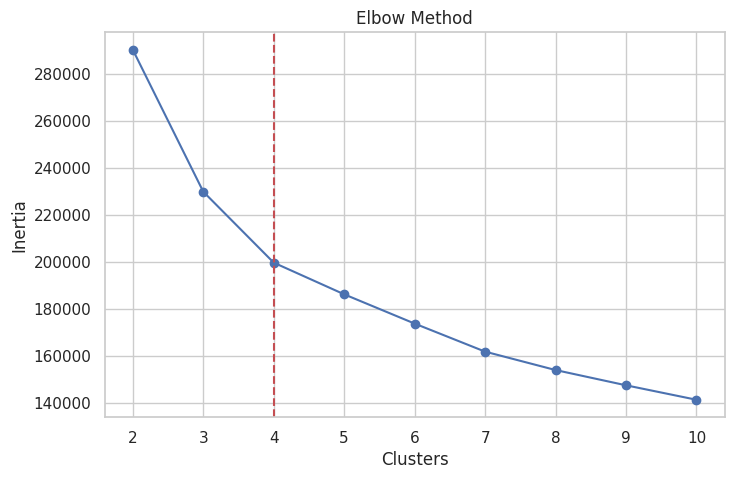

In [38]:
# Elbow plot
plt.figure(figsize=(8,5))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.axvline(x=4, color='r', linestyle='--')
plt.grid(True)
plt.show()



In [39]:
# Apply KMeans with optimal k
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_scaled)



In [40]:
# Tune DBSCAN parameters
min_samples = 5
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(features_scaled)
distances, _ = nn.kneighbors(features_scaled)
k_distances = np.sort(distances[:, -1])



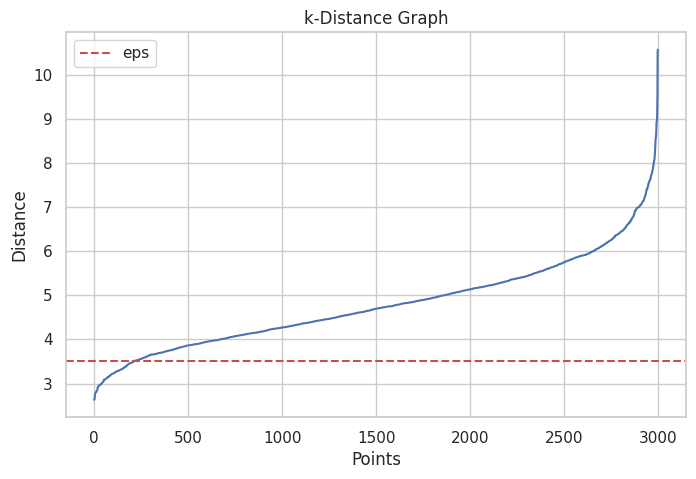

In [41]:
# k-distance plot
plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.axhline(y=3.5, color='r', linestyle='--', label='eps')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.title('k-Distance Graph')
plt.legend()
plt.grid(True)
plt.show()



In [42]:
# Apply DBSCAN
dbscan = DBSCAN(eps=3.5, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(features_scaled)



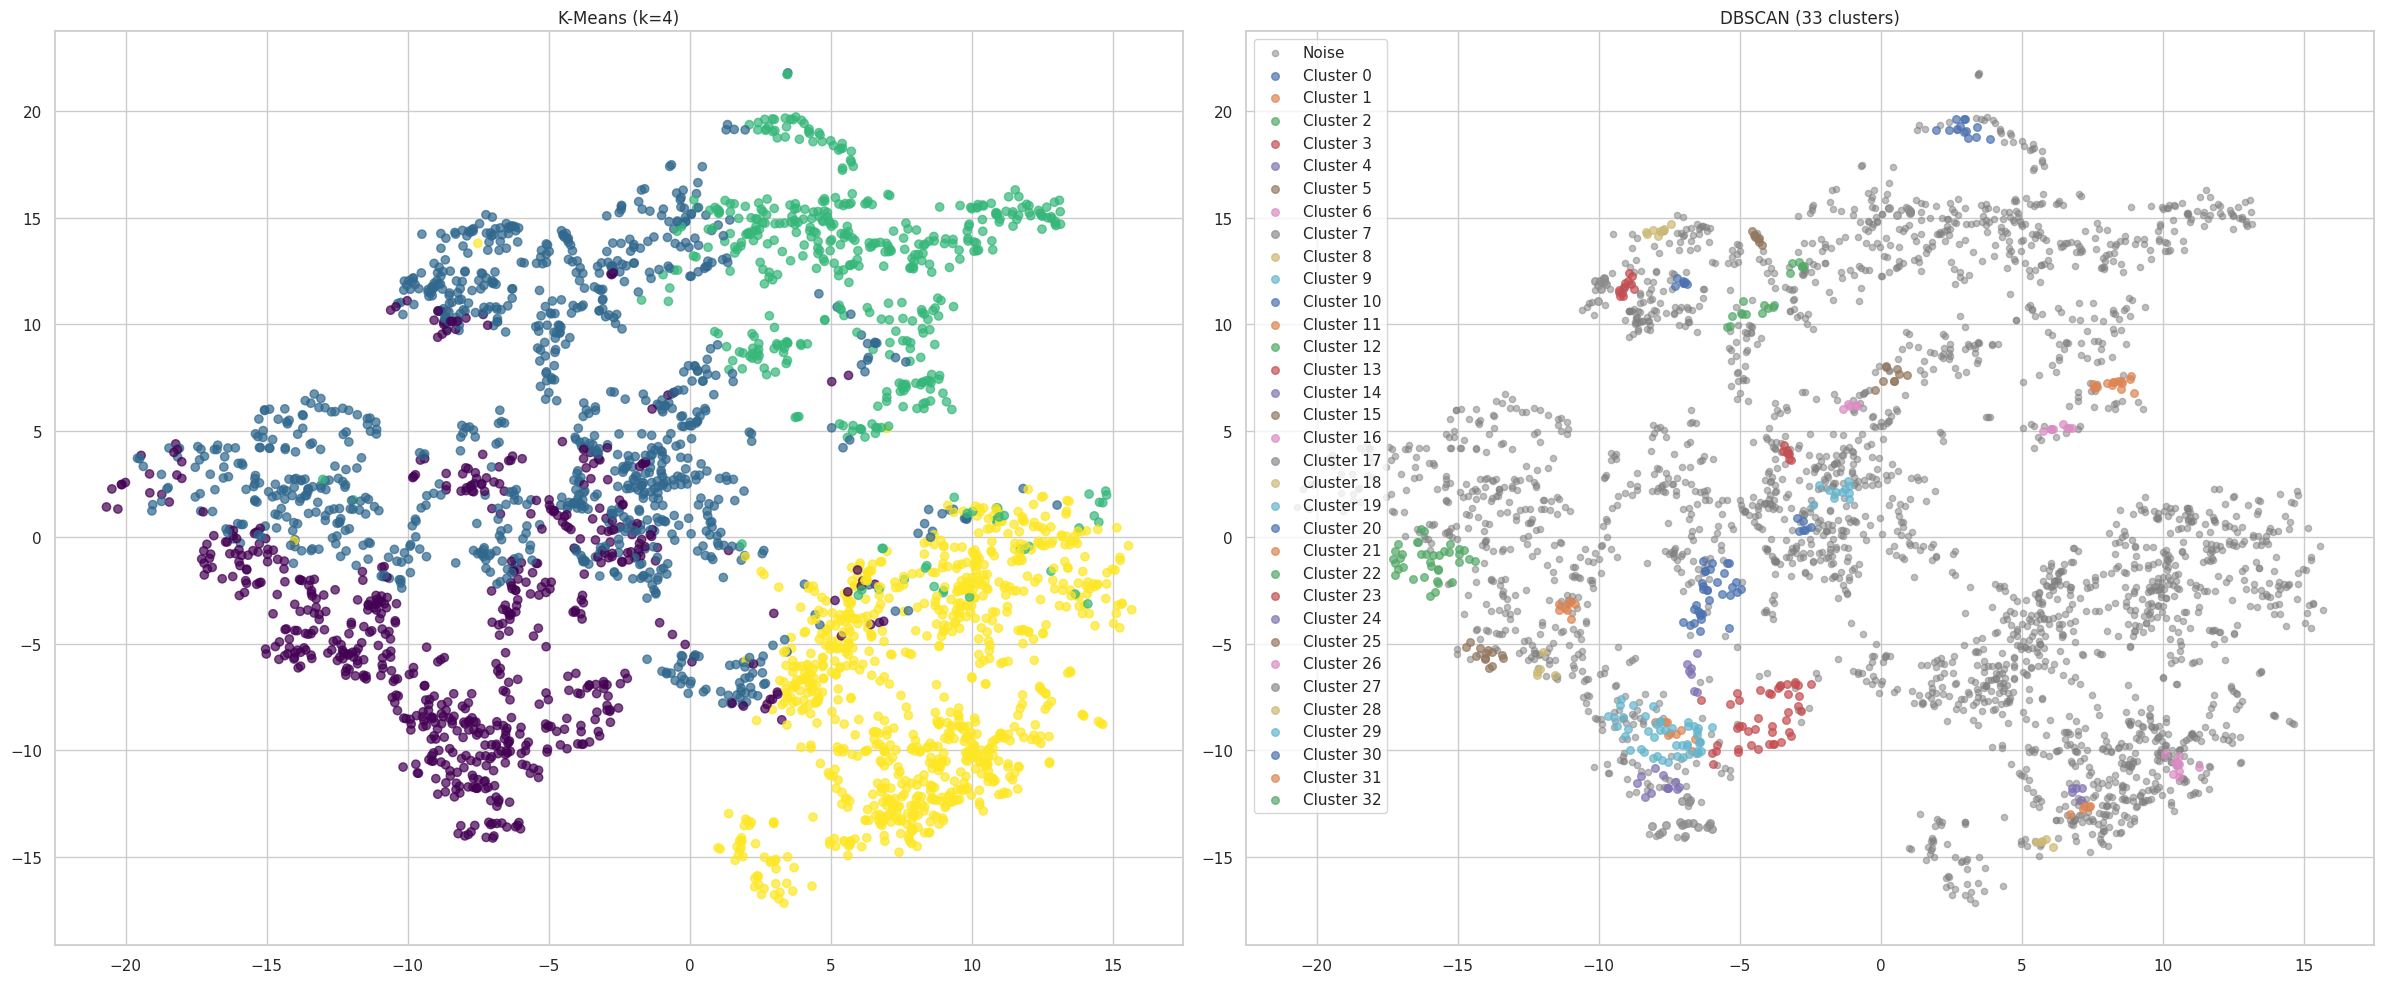

In [43]:
# Visualize clusters
plt.figure(figsize=(24,10))
plt.subplot(121)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title(f'K-Means (k={optimal_k})')
plt.subplot(122)
unique_labels = np.unique(dbscan_labels)
for label in unique_labels:
    if label == -1:
        plt.scatter(features_tsne[dbscan_labels == label, 0], features_tsne[dbscan_labels == label, 1], 
                    c='gray', alpha=0.5, s=20, label='Noise')
    else:
        plt.scatter(features_tsne[dbscan_labels == label, 0], features_tsne[dbscan_labels == label, 1], 
                    alpha=0.7, s=30, label=f'Cluster {label}')
plt.title(f'DBSCAN ({len(unique_labels)-1} clusters)')
plt.legend()
plt.tight_layout()
plt.show()



# Comment

### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

1. K-Means had  defined and reasonable separation between clusters compared to DBSCAN, which indicates many misassignments.
2. K-Means formed 4 coherent clusters matching visible patterns. On the other hand, DBSCAN produced ## fragmented clusters with many noise points.
3. K_Means worked better because Uniform cluster density exists and has clear centroids presented.
4. K-Means has provided actionable, sound categories while DBSCAN's output mostly noise and micro-clusters.
5. In Conclusion, K-Means delivered more meaningful and comprehensive clusters despite moderate scores, while DBSCAN's sensitivity to parameters and density variations caused catastrophic fragmentation.

K-Means: Silhouette=0.227, DB Index=1.524
DBSCAN: Silhouette=-0.326, DB Index=1.465
Noise points: 2601


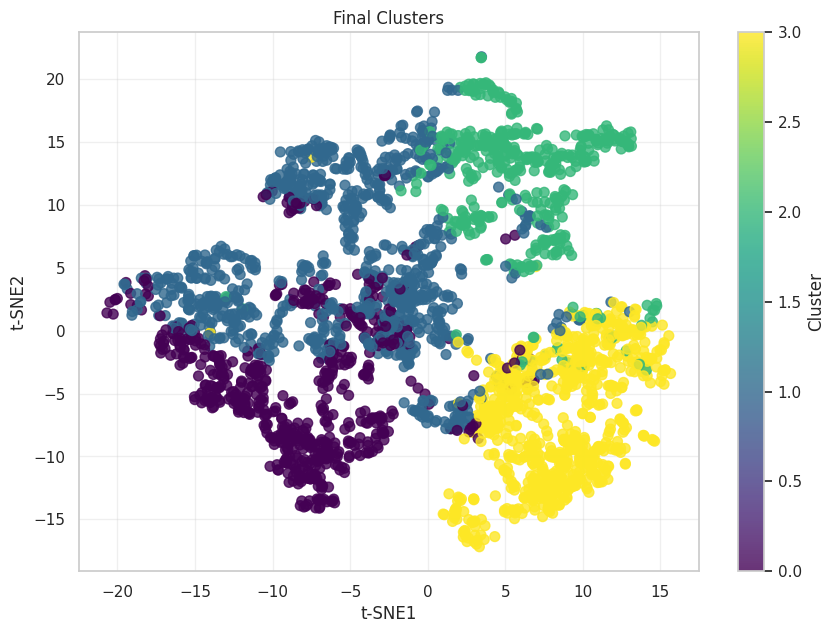

In [44]:
# Evaluate clustering performance
kmeans_silhouette = silhouette_score(features_scaled, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_scaled, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_scaled, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_scaled, dbscan_labels)
    print(f"K-Means: Silhouette={kmeans_silhouette:.3f}, DB Index={kmeans_db_index:.3f}")
    print(f"DBSCAN: Silhouette={dbscan_silhouette:.3f}, DB Index={dbscan_db_index:.3f}")
    print(f"Noise points: {sum(dbscan_labels == -1)}")
else:
    print("DBSCAN failed to form clusters")

# Final cluster visualization
plt.figure(figsize=(10, 7))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.8, s=50)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("Final Clusters")
plt.colorbar(label='Cluster')
plt.grid(alpha=0.3)
plt.show()

# Final Analysis

**Why Dimensionality Reduction Helped**
Dimensionality reduction uncovered patterns buried in the 128-dimensional feature space. PCA retained core variance, and t-SNE mapped local relationships, making clusters visible where there was once noise. It turned a data blob into a structured view, guiding algorithm choice.

**Why K-Means Outperformed DBSCAN**

K-Means thrived because the data had spherical, evenly distributed clusters,  perfect for its centroid-based logic. DBSCAN, built for irregular density, mislabeled most points as noise. Its strength in handling messy data backfired in this cleaner setup.

**Real-World Clustering Implications**
This reflects typical real-world challenges: high-dimensional data demands reduction; algorithm choice must match data shape; interpretability can be sacrificed for insight; and clustering needs both metrics and expert judgment  no silver bullets, just smart trade-offs.

**Conclusion**
In conclusion, Clustering only works when your data, algorithm, and objective are in sync. Dimensionality reduction isn’t just helpful, it’s the lens that makes hidden structures visible and actionable.








